In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm



import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE

# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [23]:
!pip3 install wordcloud

     -------------------------------------- 152.9/152.9 kB 2.3 MB/s eta 0:00:00


<h1> 1.Exploratory Data Analysis 

<h2> 1.1 Data loading and Basic Statistics

In [5]:
df= pd.read_csv(r"C:\Users\sonalive\Desktop\AppliedAI\CaseStudies\Supervised\Case study 1- Quora Question pair similarity\quora-question-pairs\train.csv\train.csv")

In [6]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [7]:
df.shape

(404290, 6)

There are 404290 rows and 6 columns in the dataset

In [8]:
df.describe()

,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614502,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


<h3> 1.1.1 Distribution of data points among output calss

                  id
is_duplicate        
0             255027
1             149263


<AxesSubplot: xlabel='is_duplicate'>

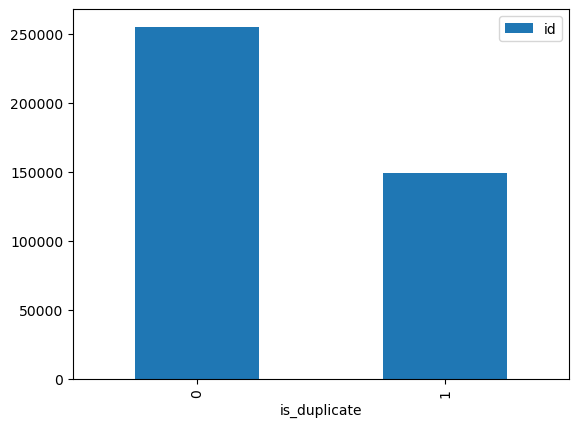

In [10]:
#check if the dataset is balanced or imbalanced
bal_imbal= df.groupby('is_duplicate')[['id']].count()
print(bal_imbal)
bal_imbal.plot.bar()

In [11]:
print(df.shape[0]- bal_imbal['id'].loc[0])

149263


In [12]:
print(" Total number of Question pairs in our tarining dataset is {}".format(df.shape[0]))
print("Total number of non-duplicated Question pairs in training dataset is {} %".format(round((bal_imbal['id'].loc[0])/df.shape[0]*100),2))
print("Total number of duplicated Question pairs in training dataset is {} %".format(round((bal_imbal['id'].loc[1])/df.shape[0]*100),2))

 Total number of Question pairs in our tarining dataset is 404290
Total number of non-duplicated Question pairs in training dataset is 63 %
Total number of duplicated Question pairs in training dataset is 37 %


<h3> 1.1.2 Total number of unique questions

In [13]:
merge_qid= pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
uniq_ques= len(np.unique(merge_qid))
qs_morethanonce=np.sum(merge_qid.value_counts()>1)
print("There are total {} unique questions in the training dataset".format(uniq_ques))
print("Number of questions which is repeated more than once is {} ,{}%".format(qs_morethanonce,round(qs_morethanonce/uniq_ques *100),2) )
print("Maximum number of times a single question repeated {}".format(max(merge_qid.value_counts())))


There are total 537933 unique questions in the training dataset
Number of questions which is repeated more than once is 111780 ,21%
Maximum number of times a single question repeated 157


<h3> 1.1.3 Check if there is any repeated pair of questions

In [14]:
pair_duplicates=df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print(" There are {} pair of duplicates in the dataset".format(pair_duplicates.shape[0]-df.shape[0]))

 There are 0 pair of duplicates in the dataset


<h3> 1.1.4 Number of occurence of each question

Text(0, 0.5, 'Number of questions')

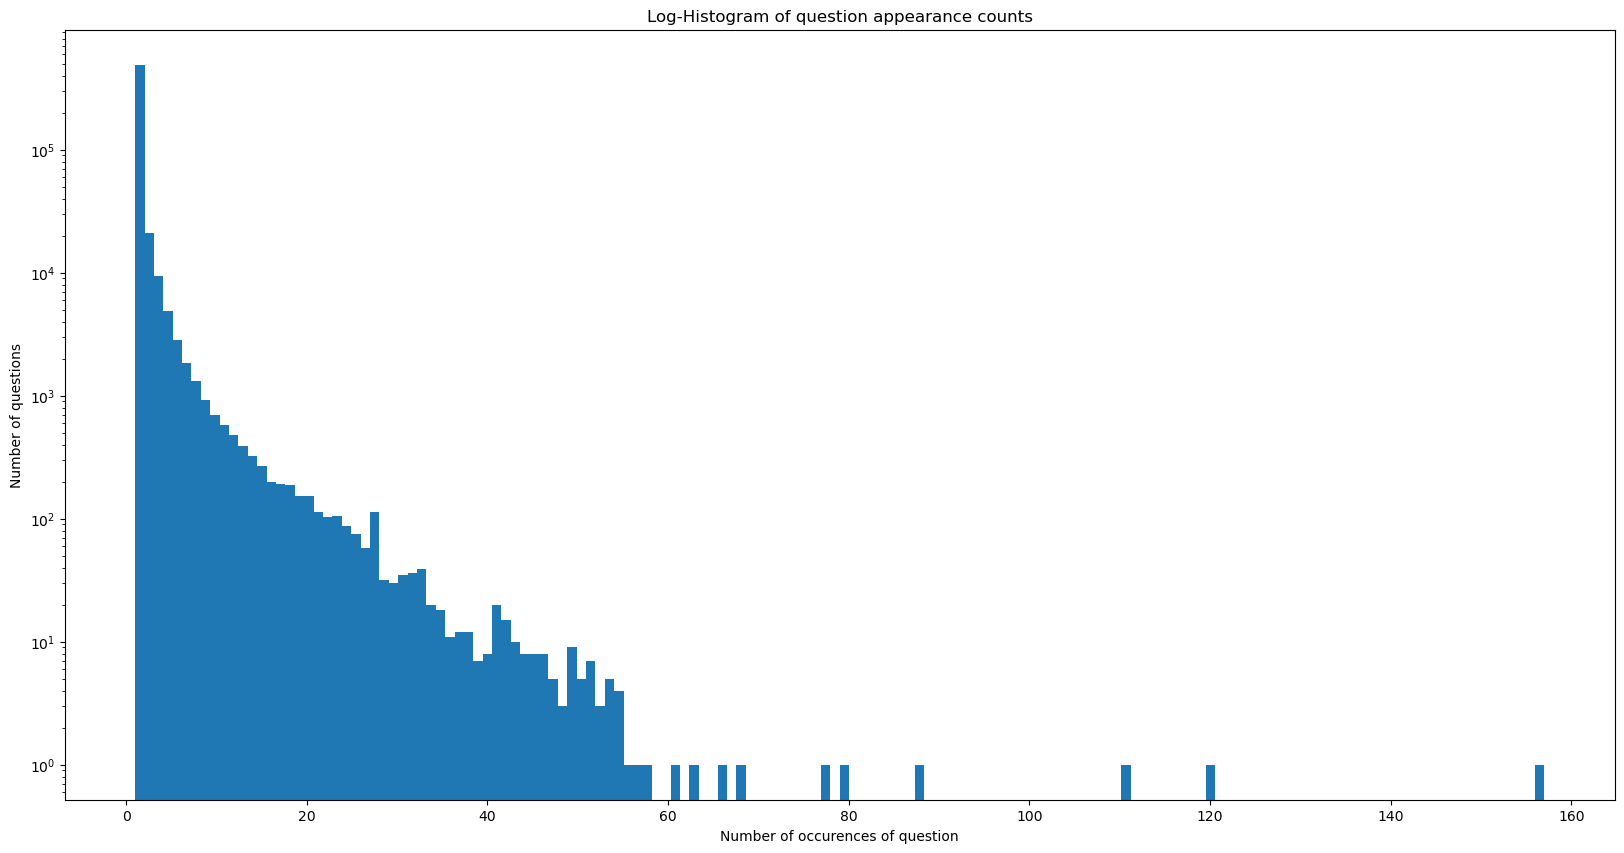

In [15]:
plt.figure(figsize=(20,10))
plt.hist(merge_qid.value_counts(),bins=150)
plt.yscale('log', nonpositive='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')

<h3> 1.1.5 Checking rows for NULL values


In [16]:
df[df.isnull().any(1)]

C:\Users\sonalive\AppData\Local\Temp\ipykernel_6648\1040708776.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  df[df.isnull().any(1)]


,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [17]:
#there are 3 rows with null values , we will fill this with ''
df=df.fillna('')
df[df.isnull().any(1)]

C:\Users\sonalive\AppData\Local\Temp\ipykernel_6648\3951924534.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  df[df.isnull().any(1)]


,id,qid1,qid2,question1,question2,is_duplicate


<h2> 1.2 Basic Feature Engineering without preprocessing <h2>

In [18]:
if os.path.isfile('df_feature_without_preprocessing_train.csv'):
    df= pd.read_csv('df_feature_without_preprocessing_train.csv')
else:
    df['freq_qid1']= df.groupby('qid1')['qid1'].transform('count')
    df['freq_qid2']= df.groupby('qid2')['qid2'].transform('count')
    df['lenq1']=df['question1'].str.len()
    df['lenq2']=df['question2'].str.len()
    df['q1_word_count']=df['question1'].transform(lambda x: len(x.split(' ')))
    df['q2_word_count']=df['question2'].transform(lambda x: len(x.split(' ')))


    def Word_Common(row):
        w1= set(map(lambda x: x.lower().strip() , row['question1'].split(' ')))
        w2= set(map(lambda x: x.lower().strip() , row['question2'].split(' ')))
        return (1.0 * len( w1 & w2))
    df['word_common']= df.apply(Word_Common,axis=1)

    def Word_Total(row):
        w1= set(map(lambda x: x.lower().strip() , row['question1'].split(' ')))
        w2= set(map(lambda x: x.lower().strip() , row['question2'].split(' ')))
        return (1.0 * len(w1) + len(w2))
    df['word_total']= df.apply(Word_Total,axis=1)

    def Word_Share(row):
        w1= set(map(lambda x: x.lower().strip() , row['question1'].split(' ')))
        w2= set(map(lambda x: x.lower().strip() , row['question2'].split(' ')))
        return (1.0 * len( w1 & w2)/(len(w1) + len(w2)))
    df['word_share']= df.apply(Word_Share,axis=1)


    df['freq_qid1 + freq_qid2']= df['freq_qid1']+ df['freq_qid2']
    df['freq_qid1 - freq_qid2']= abs(df['freq_qid1']- df['freq_qid2'])
    
    df.to_csv('df_feature_without_preprocessing_train.csv',index=False)




In [19]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,lenq1,lenq2,q1_word_count,q2_word_count,word_common,word_total,word_share,freq_qid1 + freq_qid2,freq_qid1 - freq_qid2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


<h2> 1.3 Text Preprocessing <h2>

1. Convert the letters to Lowercase
2. Decontract the phrase
3. Perform Stemming
4. Remove the HTML tags
5. Remove Stopwords
6. Remove Punctuations


In [4]:
if os.path.isfile('df_feature_without_preprocessing_train.csv'):
    df= pd.read_csv('df_feature_without_preprocessing_train.csv')
    df=df.fillna('')
    
else:
    print(" Please check above code if the file has been generated or not")

In [5]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,lenq1,lenq2,q1_word_count,q2_word_count,word_common,word_total,word_share,freq_qid1 + freq_qid2,freq_qid1 - freq_qid2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [6]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = phrase.replace("%", " percent ")
    phrase = phrase.replace("₹", " rupee ")
    phrase = phrase.replace("$", " dollar ")
    phrase = phrase.replace("€", " euro ")
    phrase = phrase.replace('\\r', ' ')
    phrase = phrase.replace('\\n', ' ')
    phrase = phrase.replace('\\"', ' ')
    
    return phrase

In [9]:
stop_words = set(stopwords.words('english'))
def preprocess_text(text_data):
    preprocessed_text=[]
    for sentence in tqdm(text_data):
        text= decontracted(sentence)
        text= str(text).lower()
        port= PorterStemmer()  # For word stemming
        text=port.stem(text)
        ex= BeautifulSoup(text)
        text= ex.get_text()
        text = re.sub('[^A-Za-z0-9]+', ' ', text) # Remove Punctuations
        """
        text=word_tokenize(text)
        text= ' '.join(w for w in text if w not in stop_words)
        
        for t in temp1:
            for w in t.split():
                if w not in stop_words:
                    print(w)
        """
        
        preprocessed_text.append(text)
    return preprocessed_text
    
       

In [10]:
preprocessed_question1= preprocess_text(df['question1'].values)
preprocessed_question2= preprocess_text(df['question2'].values)

100%|████████████████████████████████████████████████████████████████████████| 404290/404290 [02:04<00:00, 3236.74it/s]


In [14]:
df['preprocessed_question1']= preprocessed_question1
df['preprocessed_question2']= preprocessed_question2

In [15]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,lenq1,lenq2,q1_word_count,q2_word_count,word_common,word_total,word_share,freq_qid1 + freq_qid2,freq_qid1 - freq_qid2,preprocessed_question1,preprocessed_question2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,why am i mentally very lonely how can i solve it,find the remainder when math 23 24 math is div...
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water


<h2> 1.4 Advanced Feature Engineering <h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [27]:
#https://www.jashds.com/blog/2019/05/13/fuzzy-stringmatching-python#:~:text='.,differences%20existing%20between%20both%20strings.
stop_words = set(stopwords.words('english'))
safe_div=0.001 # to get result upto 4 decimal places
token_features=[0.0]*10 #Initialize array with 10 elements

def get_token_features(q1,q2):
    token1= q1.split()
    token2= q2.split()
    
    q1_stops = set([sw for sw in token1 if sw in stop_words])
    q2_stops = set([sw for sw in token2 if sw in stop_words])
    
    q1_words= set([sw for sw in token1 if sw not in stop_words])
    q2_words= set([sw for sw in token2 if sw not in stop_words])
    
    common_word_count= len(q1_words.intersection(q2_words))
    
    common_token_count = len(set(token1).intersection(set(token2)))
    
    common_stop_count= len(q1_stops.intersection(q2_stops))
    
    token_features[0]=  common_word_count/ (min(len(q1_words),  len(q2_words))+safe_div)
    token_features[1]=  common_word_count/ (min(len(q1_words),len(q2_words))+safe_div)
    token_features[2]=  common_stop_count/ (min(len(q1_words),len(q2_words))+safe_div)
    token_features[3]=  common_stop_count/ (min(len(q1_words),len(q2_words))+safe_div)
    token_features[4]=  common_token_count/ (min(len(q1_words),len(q2_words))+safe_div)
    token_features[5]=  common_token_count/ (min(len(q1_words),len(q2_words))+safe_div)
    token_features[6]= int(token1[-1]==token2[-1])
    token_features[7]= int(token1[0]==token2[0])
    token_features[8]= abs(len(token1)-len(token2))
    token_features[9]= (len(token1)+ len(token2))/2
                                             
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["preprocessed_question1"], x["preprocessed_question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
    
    #Computing Fuzzy Features and Merging with Dataset

    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["preprocessed_question1"], x["preprocessed_question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["preprocessed_question1"], x["preprocessed_question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["preprocessed_question1"], x["preprocessed_question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["preprocessed_question1"], x["preprocessed_question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["preprocessed_question1"], x["preprocessed_question2"]), axis=1)
    return df                                         
                                             
                                             
    
    
    
    
    
    

In [6]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


<h2> 1.5 Analysis of Extracted Features <h2>

<h3> 1.5.1 Create wordcloud of duplicate and Non-Duplicate questions

In [19]:
df_duplicate = df[df['is_duplicate']==1]
df_nonduplicate = df[df['is_duplicate']==0]

dup_ques= np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
nondup_ques= np.dstack([df_nonduplicate["question1"], df_nonduplicate["question2"]]).flatten()

print("No. of duplicate question in the dataset is {}".format(len(dup_ques)))
print("No. of non duplicate questions in the dataset is {}".format(len(nondup_ques)))

#Saving it into a text file 
np.savetxt('train_p.txt', dup_ques, delimiter=' ', fmt='%s',encoding="utf-8")
np.savetxt('train_n.txt', nondup_ques, delimiter=' ', fmt='%s',encoding="utf-8")

No. of duplicate question in the dataset is 298526
No. of non duplicate questions in the dataset is 510054


In [21]:
#reading the text file 
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)

Word Clouds generated from duplicate pair question's text

Word Cloud for Duplicate Question pairs


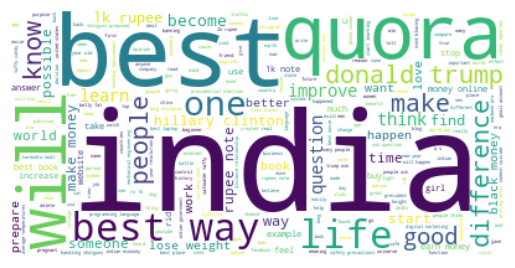

In [22]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Clouds generated from non duplicate pair question's text

Word Cloud for Non Duplicate Question pairs


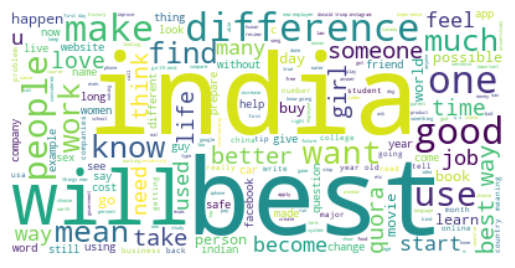

In [23]:
wc = WordCloud(background_color="white", max_words=len(textn_w), stopwords=stopwords)
wc.generate(textn_w)
print ("Word Cloud for Non Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h3> 1.5.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] 

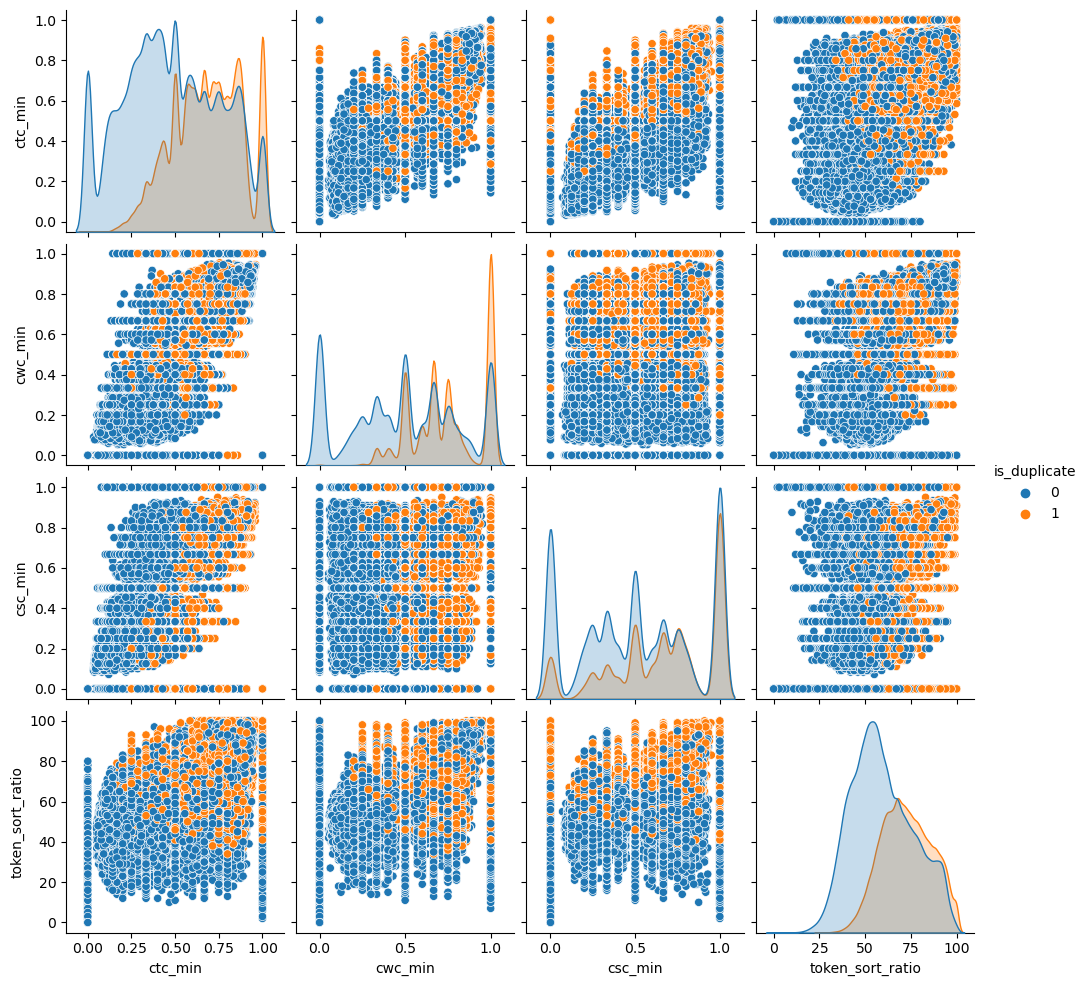

In [24]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

<h3> 1.5.3 Distribution of token sort ratio and fuzz ratio

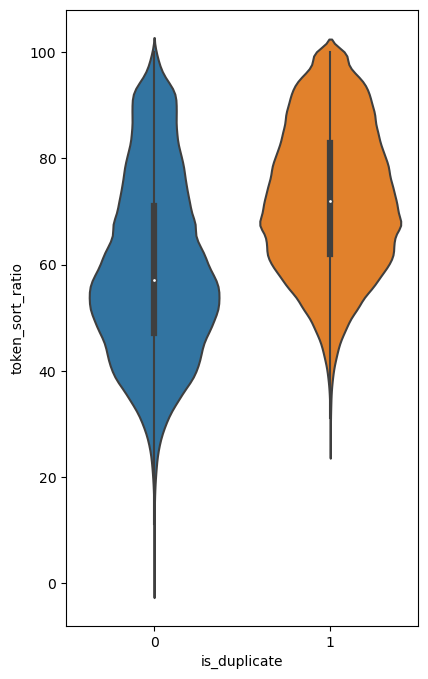

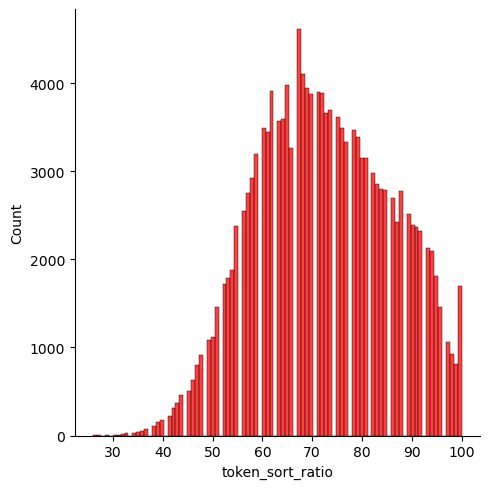

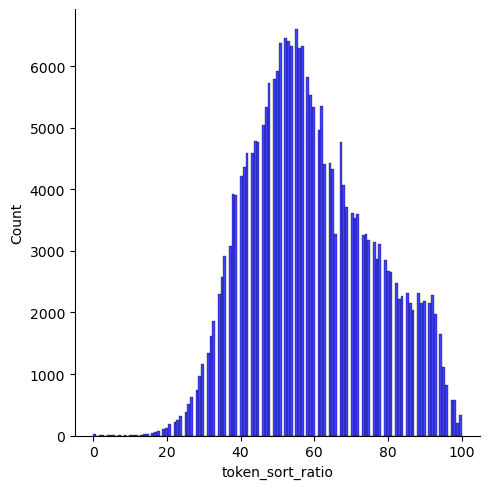

In [29]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )


sns.displot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'].loc[0:] , label = "1", color = 'red')
sns.displot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'].loc[0:] , label = "0" , color = 'blue' )
plt.show()

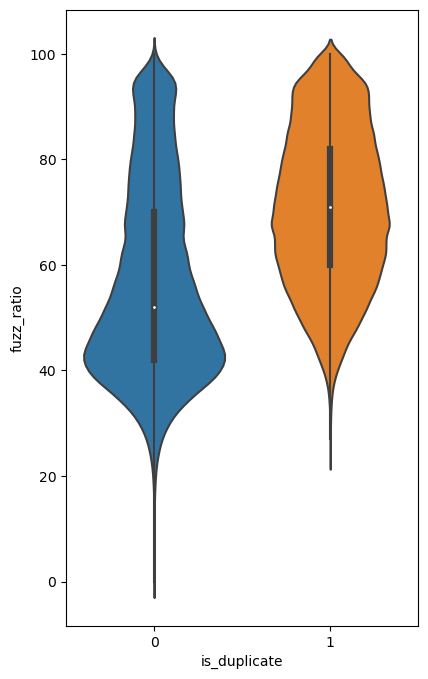

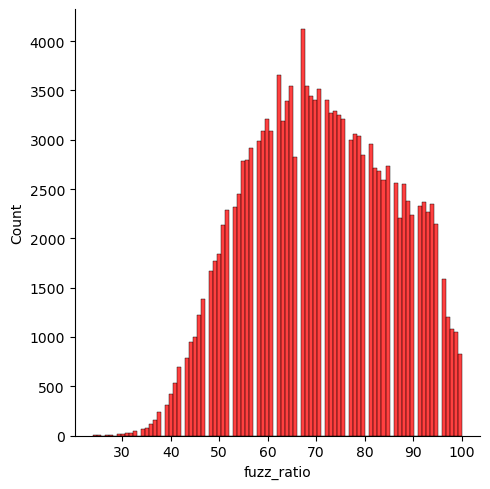

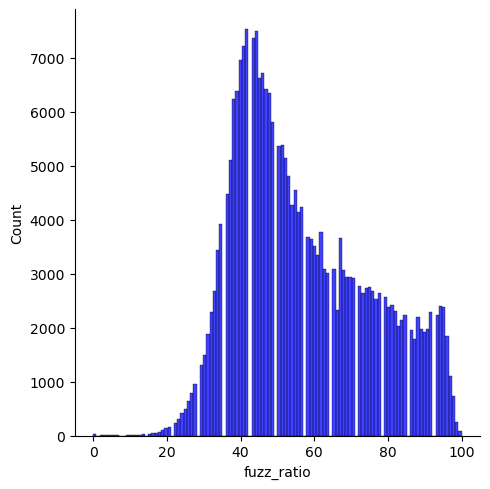

In [30]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )


sns.displot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'].loc[0:] , label = "1", color = 'red')
sns.displot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'].loc[0:] , label = "0" , color = 'blue' )
plt.show()